In [14]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, uniform

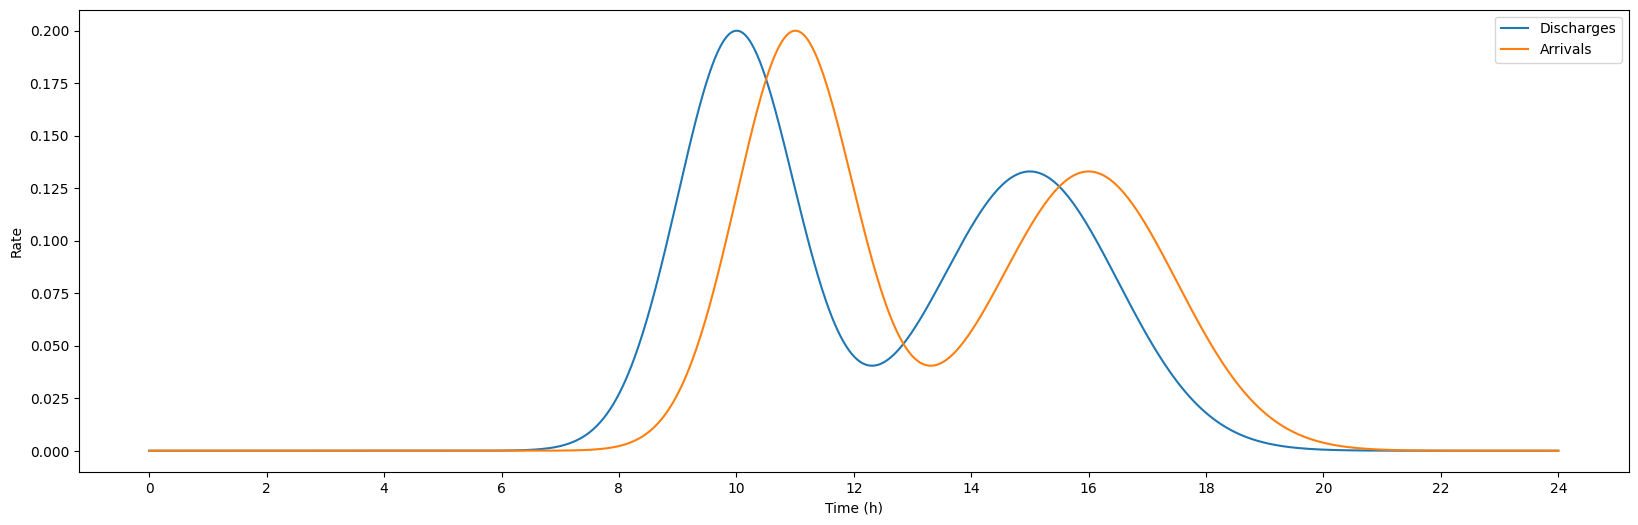

In [15]:
p = 0.55
t = np.linspace(0, 24, 1000)

class ArrivalDistribution:
    first_round_time = 9
    second_round_time = 15
    def __init__(self, p=0.5, offset=0):
        self.p = p
        self.first_peak = norm(loc=10 + offset, scale=1)
        self.second_peak = norm(loc=15 + offset, scale=1.5)

    def pdf(self, x):
        return self.p * self.first_peak.pdf(x) + (1 - self.p) * self.second_peak.pdf(x)

    def rvs(self, size=()):
        s1 = self.first_peak.rvs(size=size)
        s2 = self.second_peak.rvs(size=size)
        choice = uniform.rvs(size=size) < self.p
        return np.where(choice, s1, s2)

discharge_dist = ArrivalDistribution()
admission_dist = ArrivalDistribution(offset=1)


fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.plot(t, discharge_dist.pdf(t), label="Discharges")
ax.plot(t, admission_dist.pdf(t), label="Arrivals")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Rate")
ax.set_xticks(np.arange(0, 25, 2), np.arange(0, 25, 2))
ax.legend()
plt.show()

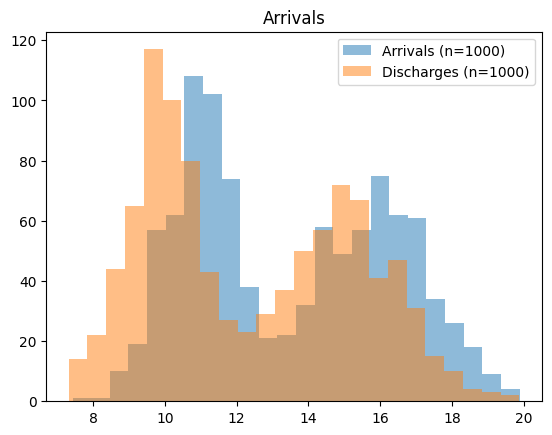

In [16]:
arrivals = admission_dist.rvs(size=1000)
discharges = discharge_dist.rvs(size=1000)

plt.title("Arrivals")
plt.hist(arrivals, alpha=0.5, bins=24, label=f"Arrivals (n={len(arrivals)})")
plt.hist(discharges, alpha=0.5, bins=24, label=f"Discharges (n={len(discharges)})")
plt.legend()
plt.show()

In [18]:
from heapq import heapify, heappop, heappush
from dataclasses import dataclass

In [37]:
@dataclass
class Event:
    time: float

    def __lt__(self, other):
        return self.time < other.time

@dataclass
class PatientAdmitted(Event):
    ward_id: int

@dataclass
class PatientDischarged(Event):
    ward_id: int

@dataclass
class BedArrivedWashing(Event):
    pass

@dataclass
class BedfinishedWashing(Event):
    pass


PatientArrived(time=0.1, ward_id=1)

In [ ]:
def simulate_system(admission_dist, discharge_dist, service_time_dist, n_patients=200):

    admission_times = admission_dist.rvs(size=n_patients)
    discharge_times = discharge_dist.rvs(size=n_patients)

    events = [PatientAdmitted(time, 0) for time in admission_times]
    events += [PatientDischarged(time, 0) for time in discharge_times]
    heapify(events)

    events_processed = []

    dirty_buffer = 0
    clean_buffer = 0

    washer_ready = True

    while events:
        event = heappop(events)
        
        match event:
            case PatientDischarged(time=t):
                dirty_buffer += 1
                transport_time = 0 # <---- YO
                heappush(events, BedArrivedWashing(t + transport_time))
            case BedArrivedWashing(time=t):
                if washer_ready:
                    washer_ready = False
                    dirty_buffer -= 1
                    k = 200
                    heappush(events, BedfinishedWashing(t + k + service_time_dist.rvs()))
            case BedfinishedWashing(time=t):
                clean_buffer += 1

                if dirty_buffer > 0:
                    washer_ready = False
                    dirty_buffer -= 1
                    k = 200
                    heappush(events, BedfinishedWashing(t + k + service_time_dist.rvs()))
                else:
                    washer_ready = True

        events_processed.append(event)

    return events_processed

In [46]:
simulate_system(admission_dist, discharge_dist, expon(scale=12), n_patients=2)

Accepted
Blocked
Blocked


[PatientDischarged(time=np.float64(10.290034321792266), ward_id=0),
 BedArrivedWashing(time=np.float64(10.290034321792266)),
 PatientDischarged(time=np.float64(11.117634848246341), ward_id=0),
 BedArrivedWashing(time=np.float64(11.117634848246341)),
 PatientAdmitted(time=np.float64(12.265196460155458), ward_id=0),
 PatientAdmitted(time=np.float64(15.300260291526598), ward_id=0),
 BedfinishedWashing(time=np.float64(216.8353445909015)),
 BedfinishedWashing(time=np.float64(421.7438203302468))]